In [127]:
import nibabel as nib
import os
import numpy as np
from scipy.stats import norm
import scipy
import pandas as pd
import matplotlib.pyplot as plt


import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import scipy.stats

base_dir = '/Volumes/camille/IBMA_simu/'

nrep = 9;

wth_n20 = dict()
hat_taus = dict()
for wth in ['05', '10', '20', '40', '80', 'diff']:
    hat_taus[wth] = []
    for r in range(1, nrep+1):
        wth_n20[wth, r] = os.path.join(
            base_dir, 
            'test1_k025_n20_btw1_wth' + wth + '_nominal', 
            '{num:04d}'.format(num=i), # Repeat
            'megaMFX/')

for [wth, r], folder in wth_n20.items():
    data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'mean_random_effects_var1.nii.gz')).get_data().flatten()
    hat_taus[wth] = np.append(hat_taus[wth], data_array)

In [122]:
np.mean(hat_taus['diff'])

1.0776312

In [131]:
print(np.mean(hat_taus['05']))
print(np.mean(hat_taus['10']))
print(np.mean(hat_taus['20']))
print(np.mean(hat_taus['40']))
print(np.mean(hat_taus['80']))
print(np.mean(hat_taus['diff']))

1.01025602695
1.02968187737
1.08407524224
1.22654240297
1.57246949154
1.07798893009


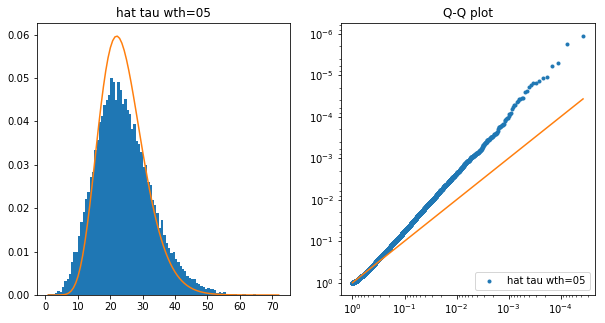

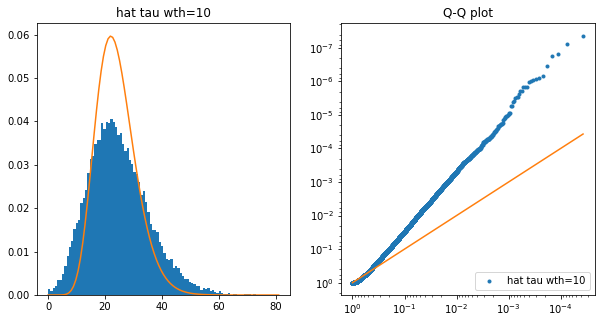

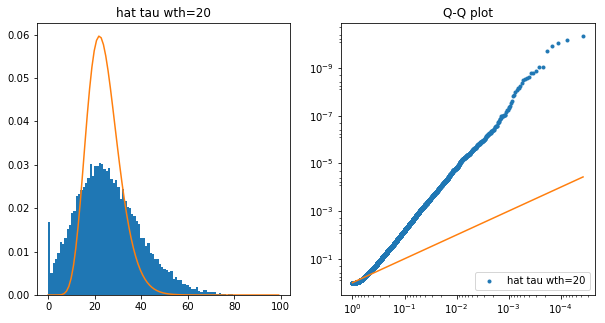

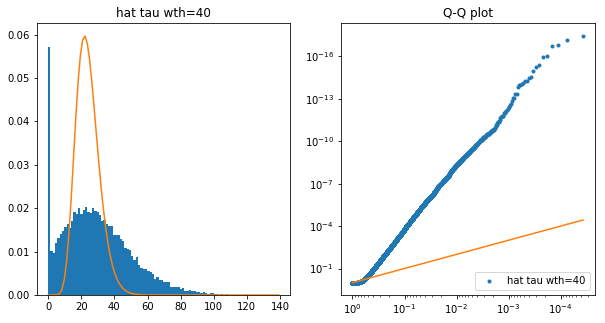

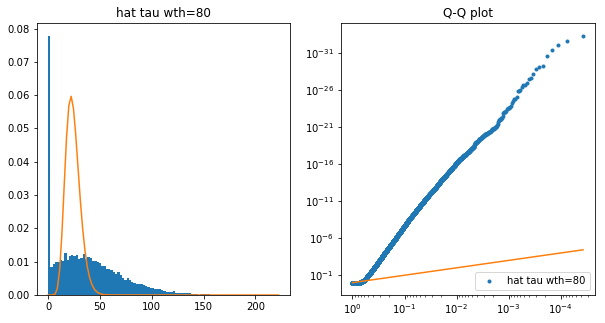

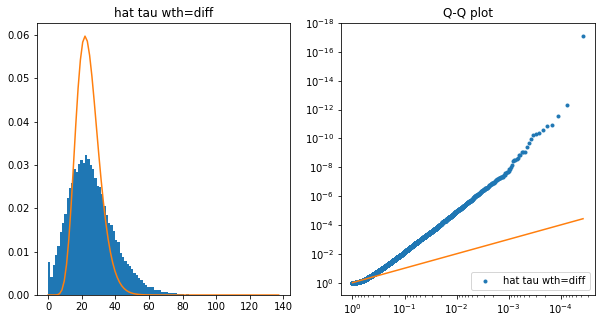

In [203]:
for wth, hat_tau in hat_taus.items():
    chi2_distribution_plot(hat_tau/(tau2/dof), 'hat tau wth=' + wth, dof)
# chi2_distribution_plot(hat_tau_10/(sigma2/dof), 'hat tau 10', dof)
# chi2_distribution_plot(hat_tau_20/(sigma2/dof), 'hat tau 20', dof)
# # chi2_distribution_plot(hat_tau_40/(sigma2/dof), 'hat tau 40', dof)
# # chi2_distribution_plot(hat_tau_80/(sigma2/dof), 'hat tau 80', dof)
# # chi2_distribution_plot(scipy.stats.chi2.rvs(dof, size=100000), 'random variate', dof)
# chi2_distribution_plot(hat_tau_diff/(sigma2/dof), 'hat tau diff', dof)


In [144]:
t_05 = nib.load(os.path.join(wth05_n20, 'stats', 'tstat1.nii.gz')).get_data().flatten()
t_10 = nib.load(os.path.join(wth10_n20, 'stats', 'tstat1.nii.gz')).get_data().flatten()
t_20 = nib.load(os.path.join(wth20_n20, 'stats', 'tstat1.nii.gz')).get_data().flatten()
t_40 = nib.load(os.path.join(wth40_n20, 'stats', 'tstat1.nii.gz')).get_data().flatten()
t_80 = nib.load(os.path.join(wth80_n20, 'stats', 'tstat1.nii.gz')).get_data().flatten()
t_diff = nib.load(os.path.join(wthdiff_n20, 'stats', 'tstat1.nii.gz')).get_data().flatten()

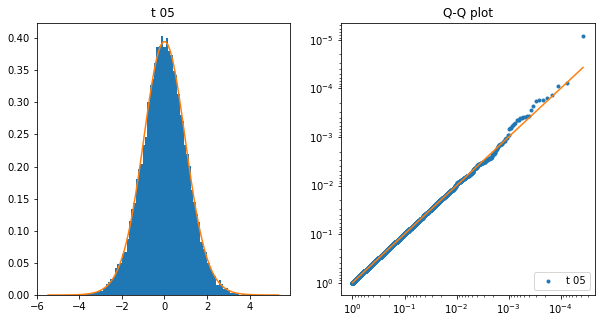

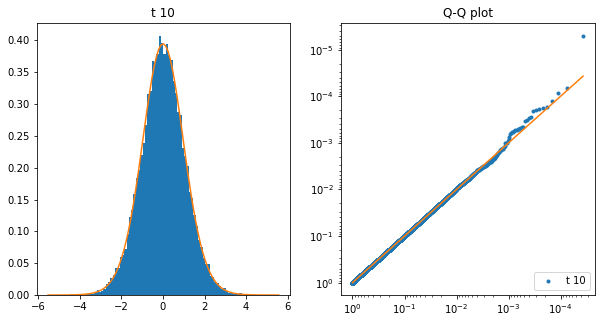

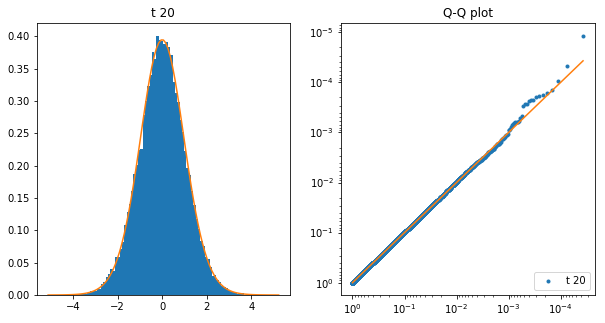

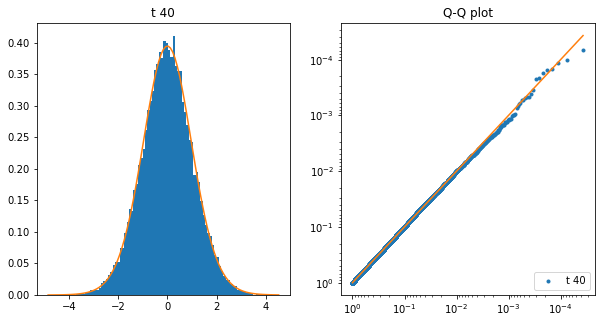

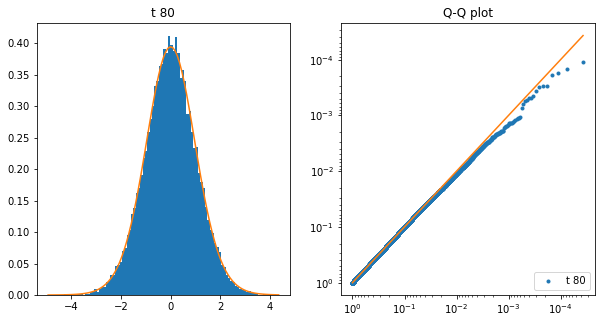

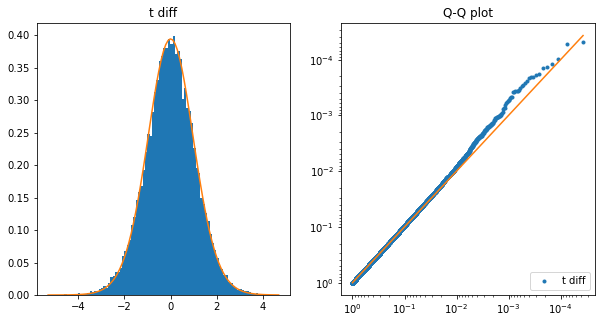

In [151]:
t_distribution_plot(t_05, 't 05', dof)
t_distribution_plot(t_10, 't 10', dof)
t_distribution_plot(t_20, 't 20', dof)
t_distribution_plot(t_40, 't 40', dof)
t_distribution_plot(t_80, 't 80', dof)
t_distribution_plot(t_diff, 't diff', dof)

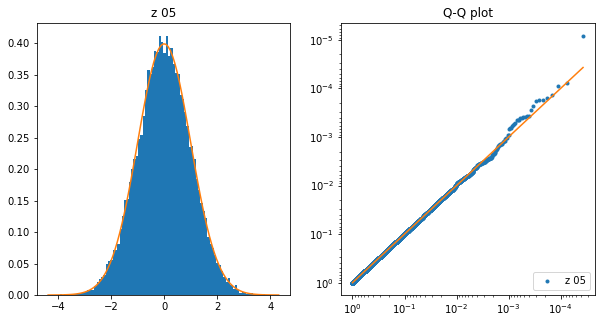

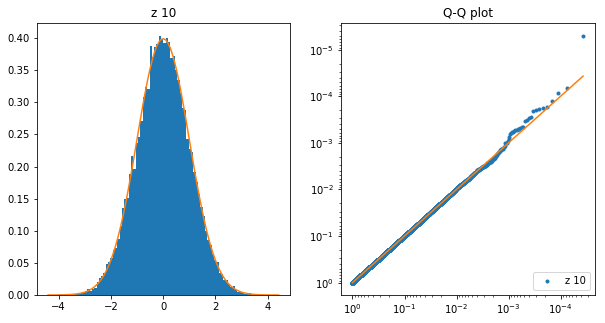

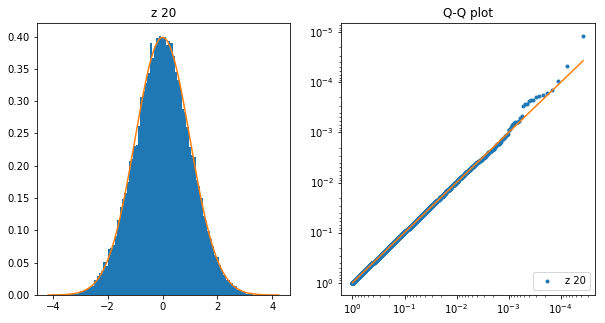

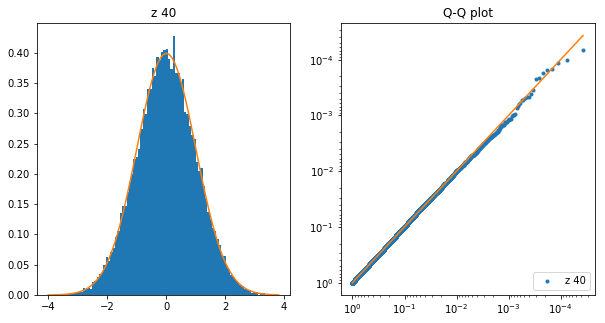

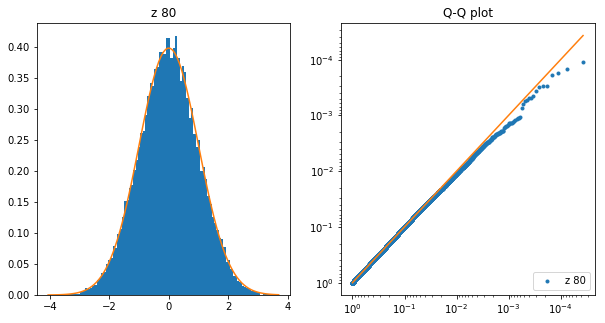

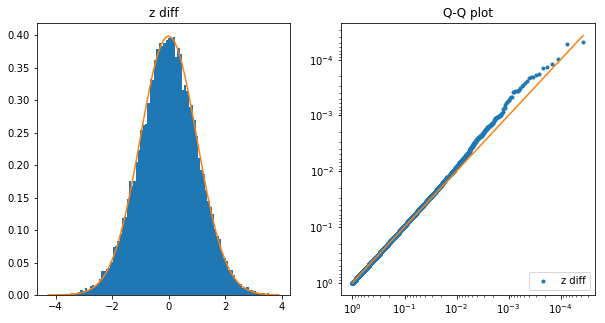

In [150]:
z_05 = nib.load(os.path.join(wth05_n20, 'stats', 'zstat1.nii.gz')).get_data().flatten()
z_10 = nib.load(os.path.join(wth10_n20, 'stats', 'zstat1.nii.gz')).get_data().flatten()
z_20 = nib.load(os.path.join(wth20_n20, 'stats', 'zstat1.nii.gz')).get_data().flatten()
z_40 = nib.load(os.path.join(wth40_n20, 'stats', 'zstat1.nii.gz')).get_data().flatten()
z_80 = nib.load(os.path.join(wth80_n20, 'stats', 'zstat1.nii.gz')).get_data().flatten()
z_diff = nib.load(os.path.join(wthdiff_n20, 'stats', 'zstat1.nii.gz')).get_data().flatten()

z_distribution_plot(z_05, 'z 05')
z_distribution_plot(z_10, 'z 10')
z_distribution_plot(z_20, 'z 20')
z_distribution_plot(z_40, 'z 40')
z_distribution_plot(z_80, 'z 80')
z_distribution_plot(z_diff, 'z diff')

In [81]:
p_uppers = dict()
p_lowers = dict()

# Pre-computed for more effeciency
data_size = 27000
p_uppers[int(data_size)] = [scipy.stats.beta.ppf(0.025, t, data_size-t+1) for t in range(1,data_size+1)]
p_lowers[int(data_size)] = [scipy.stats.beta.ppf(0.975, t, data_size-t+1) for t in range(1,data_size+1)]


In [85]:


def distribution_plot(title, data, dist, *args, **kwargs):
    np.random.seed(0)
    num_bins = 100
    

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10,5))

    # histogram plot
    n, bins, patches = ax1.hist(data, num_bins, normed=True)

#     # fit distribution and estimate parameters
#     param = dist.fit(data)
#     print(param)
#     y = dist.pdf(bins, *param[:-2], loc=param[-2], scale=param[-1])
    
    # known distribution
    y = dist.pdf(bins, *args)
    
    ax1.plot(bins, y, '-')
    ax1.set_title(title)
    
    # qq-plot plot
    p_th = [t/data.size for t in range(1,data.size+1)]

    line1, = ax2.loglog(p_th, sorted(dist.sf(data, *args)), '.', linewidth=1,
                     label=title)
    ax2.plot(p_th, p_th, '-')
    ax2.plot(p_th, p_uppers[int(data.size)], 'c-.')
    ax2.plot(p_th, p_lowers[int(data.size)], 'c-.')   
    ax2.set_title('Q-Q plot')


    ax2.legend(loc='lower right')
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.show()
    
def chi2_distribution_plot(data, title, *args, **kwargs):   
    distribution_plot(title, data, scipy.stats.chi2, *args)
    
def t_distribution_plot(data, title, *args, **kwargs):   
    distribution_plot(title, data, scipy.stats.t, *args)

def z_distribution_plot(data, title, *args, **kwargs):    
    distribution_plot(title, data, scipy.stats.norm, *args)

#### Compare cope to theoretical distribution

With MFX GLM under the null we have
```
cope ~ N(0, 1/sum(\kappa_i)) with \kappa_i = 1/(\tau^2 + \sigma_i^2)
```
i.e.:

```
cope_05 ~ N(0, 1.25/kstudies)
cope_10 ~ N(0, 1.50/kstudies)
cope_20 ~ N(0, 2/kstudies)
cope_40 ~ N(0, 3/kstudies)
cope_80 ~ N(0, 5/kstudies)

cope_diff ~ N(0, 1/(1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5))
```

##### Theoretical distribution of meta-analysic copes under H0



In [91]:
tau2 = 1
kstudies = 25
cope_th_var = dict()

def get_mfx_th_variance(tau2, sigma2_i):
    sigma2_i_ratios = [1/(tau2 + x) for x in sigma2_i]
    th_var_diff = 1/sum(sigma2_i_ratios)
    return(th_var_diff)

# From os.path.join(wth_n20['diff'], os.pardir, 'simu.mat') we see:
wth_sigma_a = [1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16]
sigma2_i = [x * 0.25 for x in wth_sigma_a]
cope_th_var['diff'] = get_mfx_th_variance(tau2, sigma2_i)
print('th_var_cope_diff=' + str(th_var_diff))

# Test calculation with constant within-study variance (sanity check)
sigma2_i = [x*0.25 for x in np.ones(kstudies)]
cope_th_var['05'] = get_mfx_th_variance(tau2, sigma2_i)

if np.isclose(get_mfx_th_variance(tau2, sigma2_i),(tau2+0.25)/kstudies):
    print('Sanity check succeded')
else:
    print('Sanity check failed!')
    print('th_var_cope_05=' + str(get_mfx_th_variance(tau2, sigma2_i)))
    print('th_var_cope_05=' + str((tau2+0.25)/kstudies))
    
cope_th_var['10'] = get_mfx_th_variance(tau2, [x*0.5 for x in np.ones(kstudies)])
cope_th_var['20'] = get_mfx_th_variance(tau2, [x*1 for x in np.ones(kstudies)])
cope_th_var['40'] = get_mfx_th_variance(tau2, [x*2 for x in np.ones(kstudies)])
cope_th_var['80'] = get_mfx_th_variance(tau2, [x*4 for x in np.ones(kstudies)])

th_var_cope_diff=0.08
Sanity check succeded


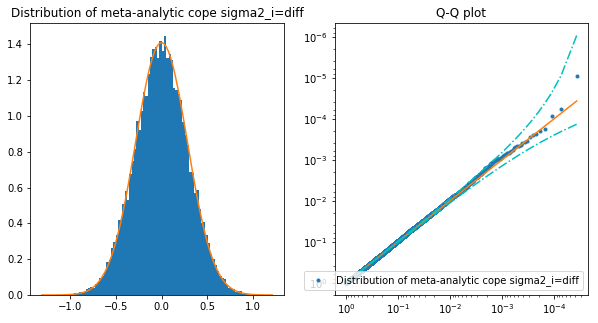

In [90]:
meta_copes = dict()
for wth, folder in wth_n20.items():
    meta_copes[wth] = nib.load(os.path.join(wth_n20[wth], 'stats', 'cope1.nii.gz')).get_data().flatten()
    
for wth in ['diff']:
    z_distribution_plot(
        meta_copes[wth], # cope to display
        'Distribution of meta-analytic cope sigma2_i=' + wth, # Title
        0, np.sqrt(cope_th_var[wth]) # Parameters of the theoretical Normal distribution
    )

Meta-analysic cope created with MFX GLM on varying within-study variance follows the theoretical distribution.


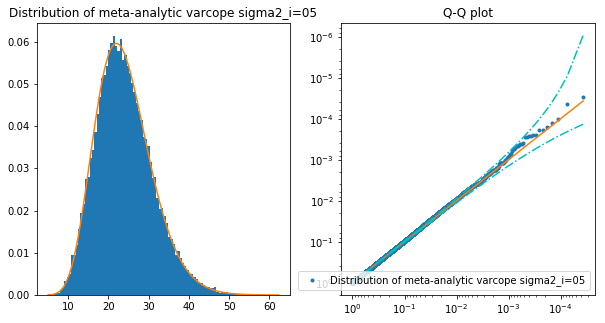

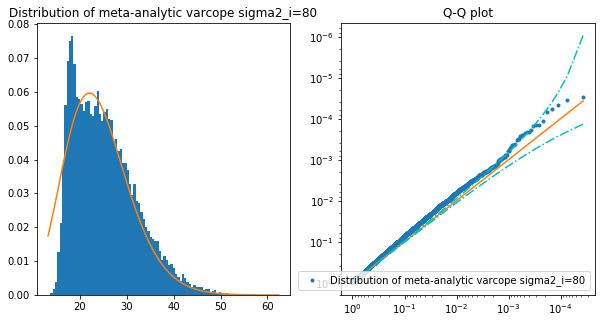

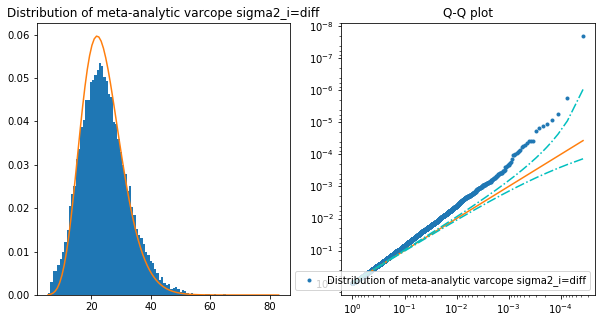

In [99]:
# np.mean(hat_tau_05)
kstudies = 25
dof = kstudies - 1

meta_varcopes = dict()
for wth, folder in wth_n20.items():
    meta_varcopes[wth] = nib.load(os.path.join(wth_n20[wth], 'stats', 'varcope1.nii.gz')).get_data().flatten()
    
for wth in ['05', '80', 'diff']:
    chi2_distribution_plot(
        meta_varcopes[wth]*dof/(cope_th_var[wth]), # varcope to display scaled by sigma2/dof
        'Distribution of meta-analytic varcope sigma2_i=' + wth, 
        dof # Parameters of the theoretical Chi2 distribution
    )

Meta-analysic varcopes created with MFX GLM:
 - within-study variance = 5 is valid (almost invalid)
 - within-study variance = 80 is invalid in places (but valid at the tail)
 - varying within-study variance invalid thoughout.


In [105]:
scipy.stats.chi2.fit(meta_varcopes['05']*dof/(cope_th_var['05']), floc=0, fscale=1)

(24.060937500000044, 0, 1)

In [104]:
scipy.stats.chi2.fit(meta_varcopes['diff']*dof/(cope_th_var['diff']), floc=0, fscale=1)

(23.965623474121138, 0, 1)

In [106]:
scipy.stats.chi2.fit(meta_varcopes['diff']*dof/(cope_th_var['diff']))

(26.924197658505932, -5.2121743623391605, 1.097284464837911)